In [1]:
# %%capture
# ! pip install numpy opencv-python pyproj Pillow pandas matplotlib requests
# ! pip install 'urllib3<2'
# ! pip install pyproj
# ! pip install supervision

## Multi-Model Model

In [1]:
import os
import io
import numpy as np
import logging
import time
import cv2

import math
import pyproj
import numpy as np
from PIL import Image
import pandas as pd

from matplotlib import pyplot as plt

import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

# Use segment anything SAM - sam has prompts in the form of Point, box NOT text

In [2]:
# %%capture
# ! pip install git+https://github.com/facebookresearch/segment-anything.git
# ! pip install -q transformers torch

Use CLIPSeg to do text based prompts

In [3]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/603M [00:00<?, ?B/s]

In [4]:
import urllib
def read_image_url(image_url):
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    image = cv2.imdecode(img_array, -1)
    return image

def read_image(image_path):
    image = cv2.imread(image_path)
    return cv2.cvtColor(image,cv2.COLOR_BGR2RGB)


(2155, 3000, 3)


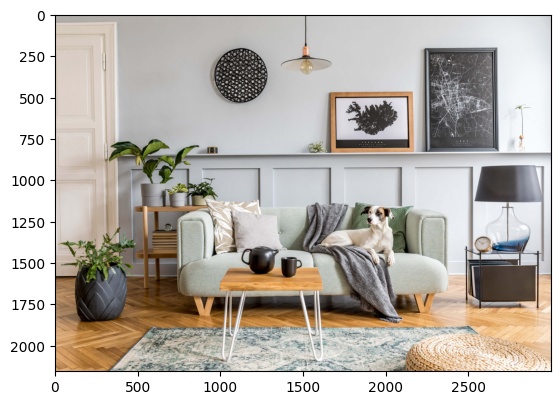

In [44]:
prompts = ["table","plant","dog","pillow", "table lamp","sofa"]
image = read_image('room2.jpg')
print(image.shape)
plt.imshow(image)

### Run Clip Model on Image

In [45]:
import torch

inputs = processor(
    text=prompts,
    images=[image] * len(prompts),
    padding="max_length",
    return_tensors="pt",
)
with torch.no_grad():  # Use 'torch.no_grad()' to disable gradient computation
    outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)
detections = outputs.logits[0]  # Assuming class index 0

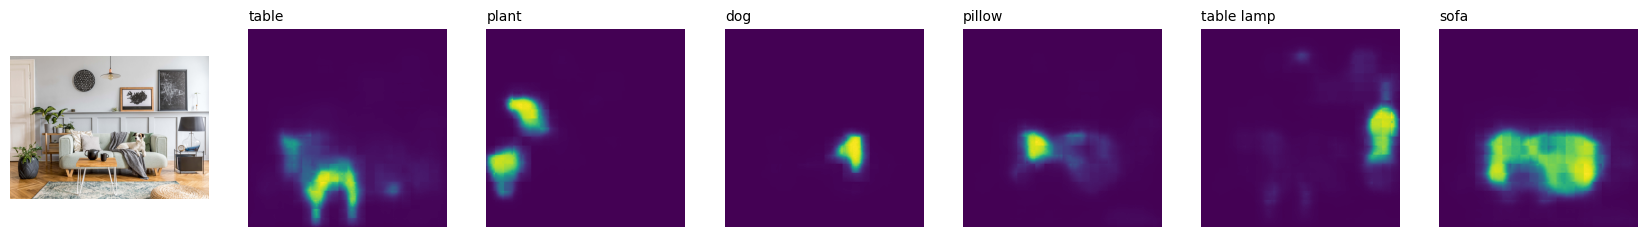

In [46]:
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];


In [8]:
# images = [torch.sigmoid(preds[i][0]) for i in range(len(prompts))]
# images = [image.detach().cpu().numpy() for image in images ]
# plt.imshow(cv2.hconcat(images))

(352, 352) <class 'numpy.ndarray'>


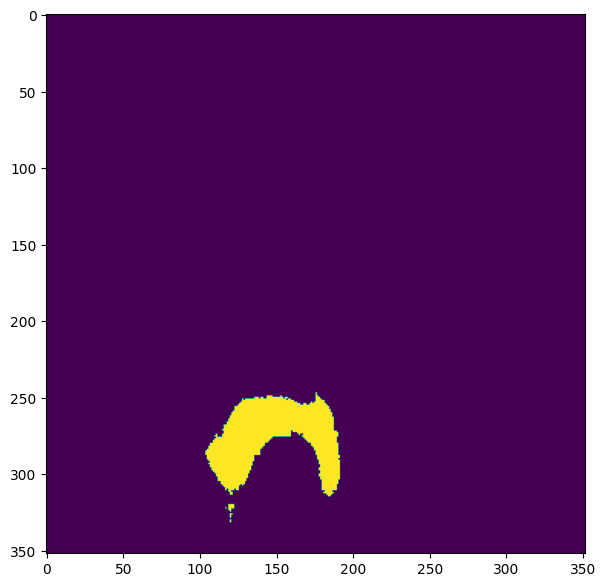

In [48]:
plt.figure(figsize=(10,7))
predicted_image =  torch.sigmoid(preds[0][0]).detach().cpu().numpy()
predicted_image = np.where(predicted_image>0.50,255,0)
print(predicted_image.shape,type(predicted_image))
plt.imshow(predicted_image)

In [74]:
def create_rgb_mask(mask,color=None):
    color = tuple(np.random.choice(range(0,256), size=3))
    gray_3_channel = cv2.merge((mask, mask, mask))
    gray_3_channel[mask==255] = color
    # gray_3_channel = cv2.cvtColor(gray_3_channel,cv2.COLOR_RGB2BGR)
    # resize_image = cv2.resize(image,mask.shape[:2])
    # image_mask = np.zeros_like(resize_image)
    # # copy your image_mask to all dimensions (i.e. colors) of your image
    # for i in range(3):
    #     image_mask[:,:,i] = mask[i].copy()
    # # apply the mask to your image
    return gray_3_channel.astype(np.uint8)


predicted_masks = []

for i in range(preds.shape[0]):
    predicted_mask =  torch.sigmoid(preds[i][0]).detach().cpu().numpy()
    predicted_mask = np.where(predicted_mask>0.50,255,0)
    # plt.imshow(create_rgb_mask(image,predicted_mask))
    predicted_masks.append(predicted_mask)


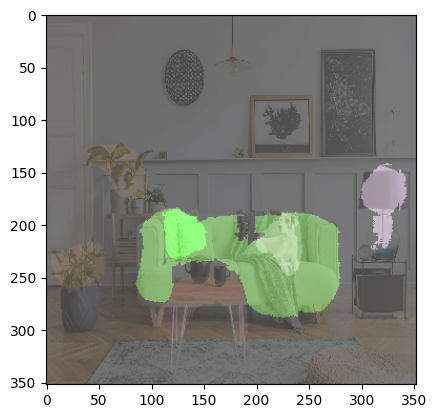

In [50]:
alpha = 0.7
resize_image = cv2.resize(image,(352,352))
resize_image_copy = resize_image.copy()

for i,predicted_image in enumerate(predicted_masks):
    resize_image_copy = cv2.addWeighted(resize_image_copy,alpha,predicted_image,1-alpha,10)

resize_image_copy = cv2.convertScaleAbs(resize_image_copy, alpha=1.8, beta=15)
plt.imshow(resize_image_copy)

In [51]:
# ! pip install segmentation_mask_overlay

In [91]:
from segmentation_mask_overlay import overlay_masks

mask_labels = [f"{prompt}_{i}" for i,prompt in enumerate(prompts)]
cmap = plt.cm.tab20(np.arange(len(mask_labels)))[..., :-1]

bool_masks = [predicted_mask.astype('bool') for predicted_mask in predicted_masks]
fig = overlay_masks(resize_image,np.stack(bool_masks,-1),labels=mask_labels,colors=cmap,alpha=0.4,beta=1)


In [92]:
fig

array([[[ 71,  70,  68],
        [ 71,  70,  68],
        [ 70,  69,  67],
        ...,
        [ 81,  83,  84],
        [ 81,  82,  84],
        [ 80,  82,  83]],

       [[ 71,  69,  67],
        [ 70,  69,  67],
        [ 70,  69,  67],
        ...,
        [ 81,  83,  84],
        [ 81,  83,  84],
        [ 81,  82,  84]],

       [[ 71,  69,  67],
        [ 70,  69,  67],
        [ 70,  69,  67],
        ...,
        [ 81,  83,  84],
        [ 81,  83,  84],
        [ 81,  82,  84]],

       ...,

       [[ 89,  70,  46],
        [ 82,  62,  38],
        [ 55,  37,  22],
        ...,
        [102, 100,  97],
        [101,  98,  93],
        [ 82,  63,  57]],

       [[ 92,  72,  49],
        [ 87,  68,  42],
        [ 83,  61,  39],
        ...,
        [102,  97,  93],
        [101,  99,  95],
        [ 92,  77,  66]],

       [[ 88,  69,  47],
        [ 89,  70,  46],
        [ 92,  72,  50],
        ...,
        [101,  96,  89],
        [102,  98,  94],
        [ 91,  71,  60]]